<a href="https://colab.research.google.com/github/DongheeKang/MachineLearning/blob/master/Batch_normalization_with_residual_connection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Batch normalization evalutaion with Residual connection 

### Practice for batch normalization 
### compare the result with bH and without BH

!nvidia-smi

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import os
import matplotlib.pyplot as plt

In [ ]:
# ResNet18 Basic Block define
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, with_BN, stride=1):
        super(BasicBlock, self).__init__()
        self.with_BN = with_BN

        # 3x3 filter using stride to reduce size 
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        if with_BN: # use batch normalization
            self.bn1 = nn.BatchNorm2d(planes) 

        # 3x3 filter do padding with same length and width each 1 
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        if with_BN: # batch normalization
            self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential() # identity mapping
        if stride != 1: 
            modules = [nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False)]
            if with_BN:
                modules.append(nn.BatchNorm2d(planes))
            self.shortcut = nn.Sequential(*modules)

    def forward(self, x):
        if self.with_BN: # batch normalization
            out = F.relu(self.bn1(self.conv1(x)))
            out = self.bn2(self.conv2(out))
        else:
            out = F.relu(self.conv1(x))
            out = self.conv2(out)
        out += self.shortcut(x) # skip connection
        out = F.relu(out)
        return out


# ResNet basic block and class
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, with_BN, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.with_BN = with_BN

        # 64 filter with 3x3 kernel
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        if with_BN: # batch normalization
            self.bn1 = nn.BatchNorm2d(64)
        # up scaling layer     
        self.layer1 = self._make_layer(block, 64, with_BN, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, with_BN, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, with_BN, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, with_BN, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, with_BN, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, with_BN, stride))
            self.in_planes = planes # change the number of channel for next layer
        return nn.Sequential(*layers)

    def forward(self, x):
        if self.with_BN: # batch normalization
            out = F.relu(self.bn1(self.conv1(x)))
        else:
            out = F.relu(self.conv1(x))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


# ResNet18 via basic -> 18
def ResNet18(with_BN):
    return ResNet(BasicBlock, [2, 2, 2, 2], with_BN)

### Load dataset 

*   CIFAR-10 dataset



In [ ]:
import torchvision
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=4)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### Training and testing for classification problem

In [ ]:
# cross entropy loss function
criterion = nn.CrossEntropyLoss() 


def train(net, optimizer, epoch, step):
    net.train()
    correct = 0 # target image number
    total = 0 # total image number
    steps = [] # step = epoch
    losses = [] # loss in each epoch

    for _, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.cuda(), targets.cuda()

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()
        total += targets.size(0)

        steps.append(step)
        losses.append(loss.item())
        step += 1

    return correct / total, steps, losses


def test(net, optimizer, epoch):
    net.eval()
    correct = 0
    total = 0 
    loss = 0 

    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.cuda(), targets.cuda()

        outputs = net(inputs)
        loss += criterion(outputs, targets).item()

        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()
        total += targets.size(0)

    return correct / total, loss

### Training without *BN*

In [ ]:
print('Initialize model parameters')
net = ResNet18(with_BN=False).cuda()
learning_rate = 0.01
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('Total number of hyper-parameters:', total_params)

Initialize model parameters
Total number of hyper-parameters: 11164362


In [ ]:
without_BN_train_accuracies = []
without_BN_steps = []
without_BN_train_losses = []
without_BN_test_accuracies = []
without_BN_test_losses = []

epochs = 20

for epoch in range(0, epochs):
    print(f'[ Epoch: {epoch}/{epochs} ]')
    train_accuracy, steps, train_losses = train(net, optimizer, epoch, len(without_BN_steps))
    without_BN_train_accuracies.append(train_accuracy)
    without_BN_steps.extend(steps)
    without_BN_train_losses.extend(train_losses)
    print(f'Train accuracy = {train_accuracy * 100:.2f} / Train loss = {sum(train_losses)}')

    test_accuracy, test_loss = test(net, optimizer, epoch)
    without_BN_test_accuracies.append(test_accuracy)
    without_BN_test_losses.append(test_loss)
    print(f'Test accuracy = {test_accuracy * 100:.2f} / Test loss = {test_loss}')

[ Epoch: 0/20 ]


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train accuracy = 15.99 / Train loss = 858.3617113828659
Test accuracy = 23.69 / Test loss = 202.93071246147156
[ Epoch: 1/20 ]
Train accuracy = 27.25 / Train loss = 765.973347067833
Test accuracy = 34.72 / Test loss = 180.105482339859
[ Epoch: 2/20 ]
Train accuracy = 34.62 / Train loss = 696.4544105529785
Test accuracy = 39.90 / Test loss = 164.7159913778305
[ Epoch: 3/20 ]
Train accuracy = 39.91 / Train loss = 640.191107749939
Test accuracy = 42.57 / Test loss = 156.01553905010223
[ Epoch: 4/20 ]
Train accuracy = 43.94 / Train loss = 598.8853282928467
Test accuracy = 46.95 / Test loss = 147.15593361854553
[ Epoch: 5/20 ]
Train accuracy = 47.56 / Train loss = 566.0737364292145
Test accuracy = 47.44 / Test loss = 145.47958099842072
[ Epoch: 6/20 ]
Train accuracy = 49.89 / Train loss = 540.2169841527939
Test accuracy = 53.13 / Test loss = 129.42708897590637
[ Epoch: 7/20 ]
Train accuracy = 53.60 / Train loss = 505.4877862930298
Test accuracy = 54.22 / Test loss = 130.40078222751617
[ Epo

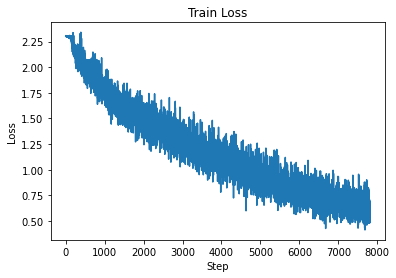

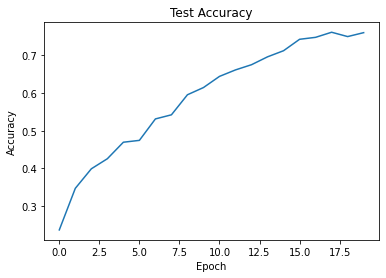

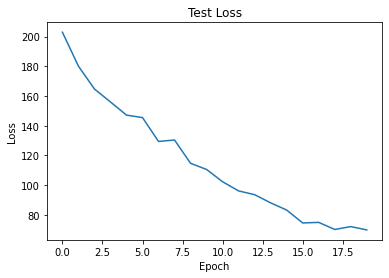

In [ ]:
# visualization
plt.plot(without_BN_steps, without_BN_train_losses)
plt.title('Train Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

plt.plot([i for i in range(len(without_BN_test_accuracies))], without_BN_test_accuracies)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.plot([i for i in range(len(without_BN_test_losses))], without_BN_test_losses)
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### Training with BN

In [ ]:
print('Initialize model parameters')
net = ResNet18(with_BN=True).cuda()
learning_rate = 0.01
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('Total number of hyper-parameters:', total_params)

Initialize model parameters
Total number of hyper-parameters: 11173962


In [ ]:
with_BN_train_accuracies = []
with_BN_steps = []
with_BN_train_losses = []
with_BN_test_accuracies = []
with_BN_test_losses = []

epochs = 20

for epoch in range(0, epochs):
    print(f'[ Epoch: {epoch}/{epochs} ]')
    train_accuracy, steps, train_losses = train(net, optimizer, epoch, len(with_BN_steps))
    with_BN_train_accuracies.append(train_accuracy)
    with_BN_steps.extend(steps)
    with_BN_train_losses.extend(train_losses)
    print(f'Train accuracy = {train_accuracy * 100:.2f} / Train loss = {sum(train_losses)}')

    test_accuracy, test_loss = test(net, optimizer, epoch)
    with_BN_test_accuracies.append(test_accuracy)
    with_BN_test_losses.append(test_loss)
    print(f'Test accuracy = {test_accuracy * 100:.2f} / Test loss = {test_loss}')

[ Epoch: 0/20 ]


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train accuracy = 47.94 / Train loss = 555.9199312925339
Test accuracy = 55.71 / Test loss = 127.07548248767853
[ Epoch: 1/20 ]
Train accuracy = 67.84 / Train loss = 355.0857649445534
Test accuracy = 61.92 / Test loss = 114.59983831644058
[ Epoch: 2/20 ]
Train accuracy = 75.42 / Train loss = 276.704299390316
Test accuracy = 73.59 / Test loss = 78.85306107997894
[ Epoch: 3/20 ]
Train accuracy = 79.18 / Train loss = 234.78482696413994
Test accuracy = 77.26 / Test loss = 68.04629835486412
[ Epoch: 4/20 ]
Train accuracy = 82.05 / Train loss = 202.9180667102337
Test accuracy = 81.31 / Test loss = 57.02159345149994
[ Epoch: 5/20 ]
Train accuracy = 83.83 / Train loss = 182.42834103107452
Test accuracy = 78.36 / Test loss = 63.150590389966965
[ Epoch: 6/20 ]
Train accuracy = 85.60 / Train loss = 163.26121459901333
Test accuracy = 78.80 / Test loss = 65.8374627828598
[ Epoch: 7/20 ]
Train accuracy = 86.85 / Train loss = 149.01756973564625
Test accuracy = 84.39 / Test loss = 47.34655863046646
[ E

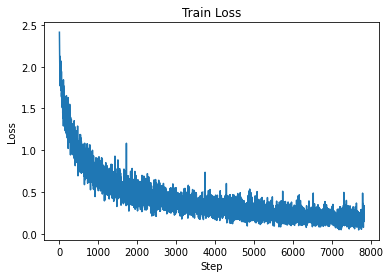

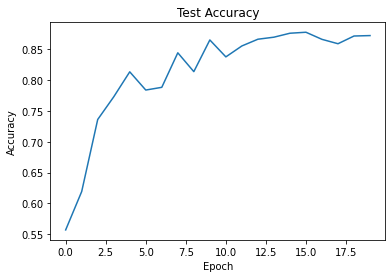

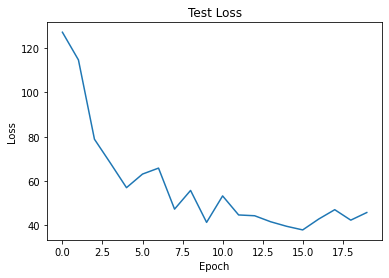

In [ ]:
plt.plot(with_BN_steps, with_BN_train_losses)
plt.title('Train Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

plt.plot([i for i in range(len(with_BN_test_accuracies))], with_BN_test_accuracies)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.plot([i for i in range(len(with_BN_test_losses))], with_BN_test_losses)
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### Comparison

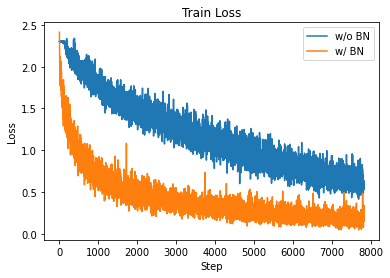

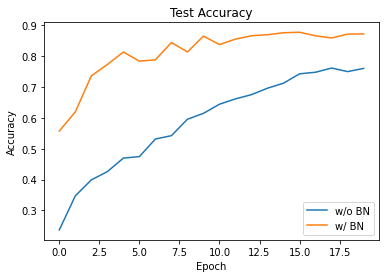

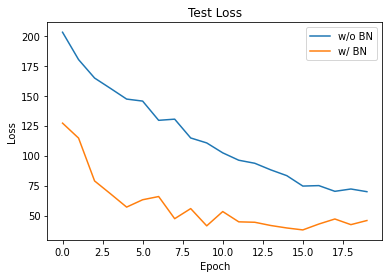

In [ ]:
plt.plot(without_BN_steps, without_BN_train_losses)
plt.plot(with_BN_steps, with_BN_train_losses)
plt.title('Train Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend(['w/o BN', 'w/ BN'])
plt.show()

plt.plot([i for i in range(len(without_BN_test_accuracies))], without_BN_test_accuracies)
plt.plot([i for i in range(len(with_BN_test_accuracies))], with_BN_test_accuracies)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['w/o BN', 'w/ BN'])
plt.show()

plt.plot([i for i in range(len(without_BN_test_losses))], without_BN_test_losses)
plt.plot([i for i in range(len(with_BN_test_losses))], with_BN_test_losses)
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['w/o BN', 'w/ BN'])
plt.show()

## Conclusion
* Batch Normalization allows to improve the accuracy with the levle of factor 2-3 times.